In [3]:
from datetime import datetime, timezone
import importlib
import os
from pathlib import Path
import sys

from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import pytz

In [4]:
# paths to common data locations - NOTE: to convert any path to a raw string, simply use str(path_instance)
dir_prj = Path.cwd().parent

dir_data = dir_prj/'data'

dir_raw = dir_data/'raw'
dir_ext = dir_data/'external'
dir_int = dir_data/'interim'
dir_out = dir_data/'processed'

gdb_raw = dir_raw/'raw.gdb'
gdb_int = dir_int/'interim.gdb'
gdb_out = dir_out/'processed.gdb'

# import the project package from the project package path - only necessary if you are not using a unique environemnt for this project
sys.path.append(str(dir_prj/'src'))
import river_levels

# load the "autoreload" extension so that code can change, & always reload modules so that as you change code in src, it gets loaded
%load_ext autoreload
%autoreload 2

# load environment variables from .env
load_dotenv(find_dotenv())

True

In [5]:
from river_levels import Gauge

In [33]:
gauge = Gauge('14226500', 'usgs')  # queets

gauge

In [35]:
obs = gauge.get_observations(period='year', period_count=10)

# obs.index = [val.astimezone(pytz.timezone('US/Pacific')) for val in obs.index]

obs.iloc[100:105]

,cfs
2011-07-23 01:00:00-07:00,2590.0
2011-07-23 01:15:00-07:00,2570.0
2011-07-23 01:30:00-07:00,2570.0
2011-07-23 01:45:00-07:00,2570.0
2011-07-23 02:00:00-07:00,2590.0


In [36]:
period_window = '28D'

mean_df = obs.cfs.rolling(period_window).mean()
std_df = obs.cfs.rolling(period_window).std()
median_df = obs.rolling(period_window).median()

obs_join = obs.join(mean_df, rsuffix='_mean').join(median_df, rsuffix='_median').join(std_df, rsuffix='_std')

obs_join.iloc[100:105]

,cfs,cfs_mean,cfs_median,cfs_std
2011-07-23 01:00:00-07:00,2590.0,2531.584158,2540.0,124.384345
2011-07-23 01:15:00-07:00,2570.0,2531.960784,2540.0,123.825486
2011-07-23 01:30:00-07:00,2570.0,2532.330097,2540.0,123.273996
2011-07-23 01:45:00-07:00,2570.0,2532.692308,2540.0,122.729719
2011-07-23 02:00:00-07:00,2590.0,2533.238095,2540.0,122.266223


In [37]:
obs_join['cfs_plus_hlf_std'] = obs_join.cfs_mean + obs_join.cfs_std / 2
obs_join['cfs_less_hlf_std'] = obs_join.cfs_mean - obs_join.cfs_std / 2

obs_join.iloc[100:105]

,cfs,cfs_mean,cfs_median,cfs_std,cfs_plus_hlf_std,cfs_less_hlf_std
2011-07-23 01:00:00-07:00,2590.0,2531.584158,2540.0,124.384345,2593.776331,2469.391986
2011-07-23 01:15:00-07:00,2570.0,2531.960784,2540.0,123.825486,2593.873527,2470.048041
2011-07-23 01:30:00-07:00,2570.0,2532.330097,2540.0,123.273996,2593.967095,2470.693099
2011-07-23 01:45:00-07:00,2570.0,2532.692308,2540.0,122.729719,2594.057167,2471.327448
2011-07-23 02:00:00-07:00,2590.0,2533.238095,2540.0,122.266223,2594.371207,2472.104984


In [10]:
obs_nrml = obs_join[~((obs_join.index.month == 2) & (obs_join.index.day == 29))].copy()
obs_nrml['joinstamp'] = [val.replace(year=1970) for val in obs_nrml.index]

obs_nrml.head()

,cfs,cfs_mean,cfs_median,cfs_std,cfs_plus_hlf_std,cfs_less_hlf_std,joinstamp
2011-07-22 00:00:00-07:00,2730.0,2730.000000,2730.0,NaN,NaN,NaN,1970-07-22 00:00:00-07:00
2011-07-22 00:15:00-07:00,2700.0,2715.000000,2715.0,21.213203,2725.606602,2704.393398,1970-07-22 00:15:00-07:00
2011-07-22 00:30:00-07:00,2710.0,2713.333333,2710.0,15.275252,2720.970959,2705.695707,1970-07-22 00:30:00-07:00
2011-07-22 00:45:00-07:00,2710.0,2712.500000,2710.0,12.583057,2718.791529,2706.208471,1970-07-22 00:45:00-07:00
2011-07-22 01:00:00-07:00,2710.0,2712.000000,2710.0,10.954451,2717.477226,2706.522774,1970-07-22 01:00:00-07:00


In [11]:
obs_mean = obs_nrml[['cfs_mean', 'cfs_plus_hlf_std', 'cfs_less_hlf_std', 'joinstamp']].groupby('joinstamp').mean()

obs_mean.head()

,cfs_mean,cfs_plus_hlf_std,cfs_less_hlf_std
joinstamp,,,
1970-01-01 00:00:00-08:00,1637.036290,2414.634576,859.438005
1970-01-01 00:15:00-08:00,1637.087581,2414.646326,859.528835
1970-01-01 00:30:00-08:00,1637.144527,2414.669213,859.619841
1970-01-01 00:45:00-08:00,1637.204411,2414.695363,859.713460
1970-01-01 01:00:00-08:00,1637.265411,2414.723400,859.807423


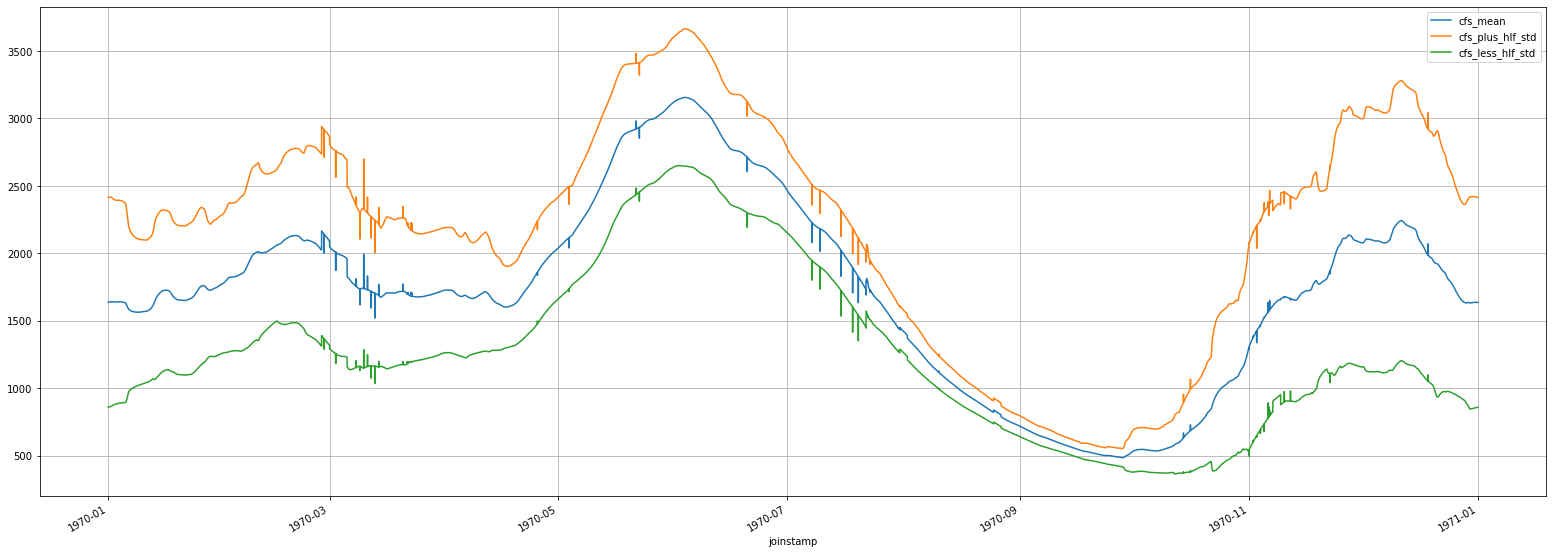

In [12]:
_ = obs_mean.plot(figsize=(27,10), grid=True)

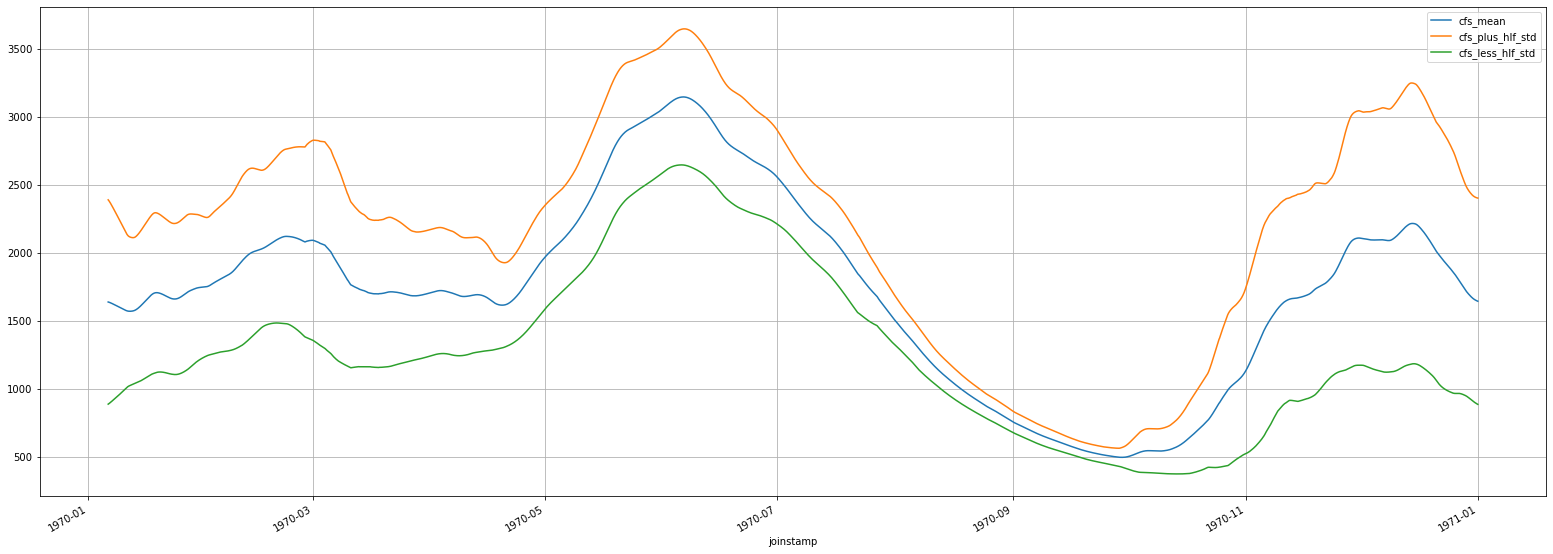

In [30]:
_ = obs_mean.rolling(window=500).mean().plot(figsize=(27,10), grid=True)